In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
from comparers import ModelComparer
from util import calc_ground_truth_constraints, constraint_matrix_to_rules
from tasks.boston_housing import make_task3, make_task4
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from clustering import make_clustering

In [2]:
clf_a, clf_b, X, y, feature_names, categorical_features, feature_precisions = make_task3('.')
comparer_ab = ModelComparer(clf_a, clf_b, feature_names)

Trying to unpickle estimator LabelBinarizer from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.
Trying to unpickle estimator MLPClassifier from version 0.24.1 when using version 0.24.2. This might lead to breaking code or invalid results. Use at your own risk.


In [3]:
clf_a, clf_c, _, _, _, _, _ = make_task4('.')
comparer_ac = ModelComparer(clf_a, clf_c, feature_names, name_b='C')

In [4]:
def load(comparison):
    if comparison == 'AB':
        task = 3
        comparer = comparer_ab
    else:
        task = 4
        comparer = comparer_ac
    with open(f'Task {task}/explanations/diffclf.shap', 'rb') as f:
        diffclf_shap_values = pickle.load(f)
    with open(f'Task {task}/explanations/indiv.shap', 'rb') as f:
        indiv_shap_values = pickle.load(f)
    with open(f'Task {task}/explanations/clustering.pickle', 'rb') as f:
        state = pickle.load(f)
    node = make_clustering(comparer, indiv_shap_values, diffclf_shap_values, focus_class=None,
                           categorical_features=categorical_features,
                           feature_precisions=feature_precisions, state=state)
    return node

In [5]:
node_ab = load('AB')
node_ac = load('AC')

# Task Description

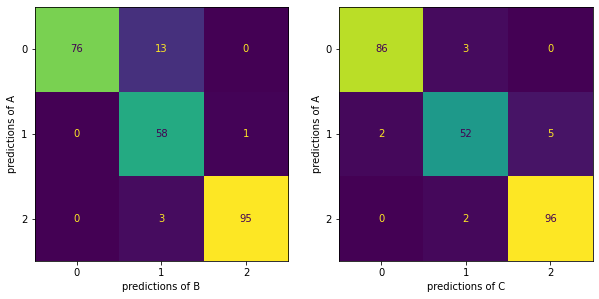

In [4]:
fig, axs = plt.subplots(ncols=2, figsize=(10, 5))
comparer_ab.plot_confusion_matrix(X, ax=axs[0])
comparer_ac.plot_confusion_matrix(X, ax=axs[1])
plt.savefig('figures/boston-cf.pdf')

In [13]:
X = pd.DataFrame(X, columns=feature_names)

In [ ]:
pd.Series().round()

In [51]:
node_ab.data.loc[node_ab.pred_classes == '(0, 1)'].describe()

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
count,13.000000,13.0,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000,13.000000
mean,1.316509,0.0,16.219231,0.598692,5.886624,1.923077,2.840883,5.846154,394.384615,19.192308,15.570054
std,1.073462,0.0,6.003980,0.063987,0.230000,0.277350,0.974075,5.474884,102.396727,2.865735,2.686952
min,0.045600,0.0,8.140000,0.538000,5.614909,1.000000,1.788300,4.000000,276.000000,14.700000,11.100000
25%,0.626837,0.0,8.140000,0.538000,5.695859,2.000000,2.100000,4.000000,307.000000,16.400000,13.510000
50%,0.976170,0.0,19.580000,0.605000,5.854000,2.000000,2.388700,4.000000,403.000000,21.000000,17.066695
75%,2.242360,0.0,21.890000,0.624000,6.020228,2.000000,3.820836,5.000000,437.000000,21.200000,17.310000
max,3.836840,0.0,21.890000,0.770000,6.319000,2.000000,4.441690,24.000000,666.000000,21.200000,18.720000


In [36]:
for comparer in [comparer_ab, comparer_ac]:
    print(comparer.name_a + ' vs. ' + comparer.name_b)
    X2 = X.copy()
    X2.insert(0, 'Label', comparer.class_names[comparer.predict_mclass_diff(X)])
    X2 = X2[np.in1d(X2['Label'], comparer.difference_class_names)]
    X2 = X2.reset_index().sort_values(['Label', 'index']).set_index('index')
    X2 = X2.set_index('Label', append=True)
    for feature, precision in zip(feature_names, feature_precisions):
        if precision == 0:
            X2[feature] = X2[feature].astype(int)
        else:
            X2[feature] = X2[feature].round(precision)
    display(X2)
    print(X2.to_latex())

A vs. B


,,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
index,Label,,,,,,,,,,,
8,"(0, 1)",3.8,0,18.10,0.77,6.25,2,2.30,24.0,666,20.2,14.19
28,"(0, 1)",2.2,0,19.58,0.60,5.85,2,2.42,5.0,403,14.7,11.64
40,"(0, 1)",2.3,0,19.58,0.60,6.32,2,2.10,5.0,403,14.7,11.10
42,"(0, 1)",1.1,0,8.14,0.54,5.70,2,3.82,4.0,307,21.0,18.26
74,"(0, 1)",0.6,0,21.89,0.62,5.73,2,2.07,4.0,437,21.2,17.25
151,"(0, 1)",0.9,0,8.14,0.54,6.02,2,4.44,4.0,307,21.0,17.07
152,"(0, 1)",2.3,0,19.58,0.60,5.88,2,2.39,5.0,403,14.7,12.03
157,"(0, 1)",1.0,0,21.89,0.62,5.76,2,2.35,4.0,437,21.2,17.31
180,"(0, 1)",0.3,0,21.89,0.62,5.69,2,1.79,4.0,437,21.2,17.19


\begin{tabular}{llrrrrrrrrrrr}
\toprule
    &        &  CRIM &  ZN &  INDUS &   NOX &    RM &  AGE &   DIS &   RAD &  TAX &  PTRATIO &  LSTAT \\
index & Label &       &     &        &       &       &      &       &       &      &          &        \\
\midrule
8   & (0, 1) &   3.8 &   0 &  18.10 &  0.77 &  6.25 &    2 &  2.30 &  24.0 &  666 &     20.2 &  14.19 \\
28  & (0, 1) &   2.2 &   0 &  19.58 &  0.60 &  5.85 &    2 &  2.42 &   5.0 &  403 &     14.7 &  11.64 \\
40  & (0, 1) &   2.3 &   0 &  19.58 &  0.60 &  6.32 &    2 &  2.10 &   5.0 &  403 &     14.7 &  11.10 \\
42  & (0, 1) &   1.1 &   0 &   8.14 &  0.54 &  5.70 &    2 &  3.82 &   4.0 &  307 &     21.0 &  18.26 \\
74  & (0, 1) &   0.6 &   0 &  21.89 &  0.62 &  5.73 &    2 &  2.07 &   4.0 &  437 &     21.2 &  17.25 \\
151 & (0, 1) &   0.9 &   0 &   8.14 &  0.54 &  6.02 &    2 &  4.44 &   4.0 &  307 &     21.0 &  17.07 \\
152 & (0, 1) &   2.3 &   0 &  19.58 &  0.60 &  5.88 &    2 &  2.39 &   5.0 &  403 &     14.7 &  12.03 \\
157 &

,,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
index,Label,,,,,,,,,,,
8,"(0, 1)",3.8,0,18.10,0.77,6.25,2,2.30,24.0,666,20.2,14.19
40,"(0, 1)",2.3,0,19.58,0.60,6.32,2,2.10,5.0,403,14.7,11.10
238,"(0, 1)",0.0,0,13.89,0.55,5.89,1,3.11,5.0,276,16.4,13.51
23,"(1, 0)",0.8,0,8.14,0.54,5.60,2,4.45,4.0,307,21.0,16.51
156,"(1, 0)",0.8,0,8.14,0.54,5.65,2,4.45,4.0,307,21.0,16.48
22,"(1, 2)",0.1,60,1.69,0.41,6.58,0,10.71,4.0,411,18.3,5.49
55,"(1, 2)",0.5,20,3.97,0.65,7.23,1,2.12,5.0,264,13.0,9.52
68,"(1, 2)",0.0,90,2.97,0.40,7.09,0,7.31,1.0,285,15.3,7.85
122,"(1, 2)",0.0,85,4.15,0.43,6.52,0,8.54,4.0,351,17.9,6.36


\begin{tabular}{llrrrrrrrrrrr}
\toprule
    &        &  CRIM &  ZN &  INDUS &   NOX &    RM &  AGE &    DIS &   RAD &  TAX &  PTRATIO &  LSTAT \\
index & Label &       &     &        &       &       &      &        &       &      &          &        \\
\midrule
8   & (0, 1) &   3.8 &   0 &  18.10 &  0.77 &  6.25 &    2 &   2.30 &  24.0 &  666 &     20.2 &  14.19 \\
40  & (0, 1) &   2.3 &   0 &  19.58 &  0.60 &  6.32 &    2 &   2.10 &   5.0 &  403 &     14.7 &  11.10 \\
238 & (0, 1) &   0.0 &   0 &  13.89 &  0.55 &  5.89 &    1 &   3.11 &   5.0 &  276 &     16.4 &  13.51 \\
23  & (1, 0) &   0.8 &   0 &   8.14 &  0.54 &  5.60 &    2 &   4.45 &   4.0 &  307 &     21.0 &  16.51 \\
156 & (1, 0) &   0.8 &   0 &   8.14 &  0.54 &  5.65 &    2 &   4.45 &   4.0 &  307 &     21.0 &  16.48 \\
22  & (1, 2) &   0.1 &  60 &   1.69 &  0.41 &  6.58 &    0 &  10.71 &   4.0 &  411 &     18.3 &   5.49 \\
55  & (1, 2) &   0.5 &  20 &   3.97 &  0.65 &  7.23 &    1 &   2.12 &   5.0 &  264 &     13.0 &   9.52

In [77]:
feature_importances_per_clf = {}
order = None
for clf in ['A', 'B', 'C']:
    with open(f'explanations/featimp-{clf.lower()}.pickle', 'rb') as f:
        feature_importances = pickle.load(f)
    if order is None:
        order = np.argsort(-feature_importances)
    feature_importances_per_clf[clf] = pd.Series(feature_importances[order],
                                                 index=pd.Index(feature_names[order], name='Feature'))

In [78]:
feature_importances = pd.concat(feature_importances_per_clf, names=['Classifier'])
feature_importances = pd.DataFrame(feature_importances, columns=['Importance']).reset_index()
feature_importances

,Classifier,Feature,Importance
0,A,LSTAT,0.995866
1,A,ZN,0.220373
2,A,INDUS,0.199342
3,A,CRIM,0.129655
4,A,RAD,0.119568
5,A,TAX,0.114244
6,A,RM,0.111313
7,A,AGE,0.093538
8,A,DIS,0.089799
9,A,PTRATIO,0.069686


# General Comparison

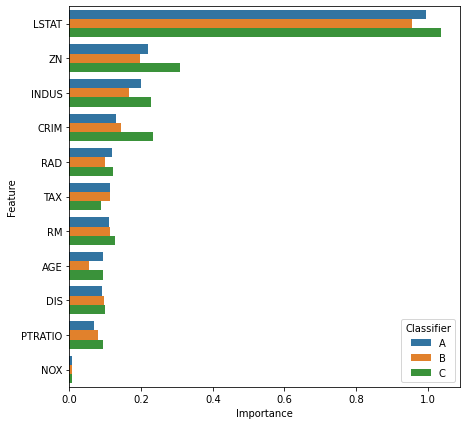

In [86]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.barplot(orient='h', data=feature_importances.reset_index(), y='Feature', x='Importance', hue='Classifier', ax=ax)
plt.savefig('figures/boston-featimp.pdf', bbox_inches='tight')

In [6]:
from clustering import make_clustering, plot_dependence_curves_for_feature, _DEFAULT_FIGSIZE

In [7]:
y_pred_a = clf_a.predict(node_ab.data).astype(str)
y_pred_b = clf_a.predict(node_ab.data).astype(str)
y_pred_c = clf_a.predict(node_ac.data).astype(str)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


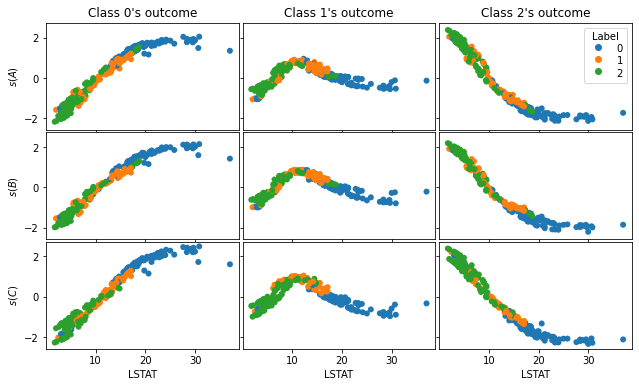

In [12]:
nrows, ncols = 3, 3
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*figsize[0], nrows*figsize[1]), sharey='all', sharex='all', squeeze=False, constrained_layout=True)
plot_dependence_curves_for_feature(node_ab, feature='LSTAT', labels=['A.0', 'A.1', 'A.2'], color=y_pred_a, color_label='$y_A$', kind='indiv', show_label_legend=False, axs=axs[0])
plot_dependence_curves_for_feature(node_ab, feature='LSTAT', labels=['B.0', 'B.1', 'B.2'], color=y_pred_b, color_label='$y_B$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[1])
plot_dependence_curves_for_feature(node_ac, feature='LSTAT', labels=['C.0', 'C.1', 'C.2'], color=y_pred_a, color_label='$y_C$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[2])
axs[0][0].set_ylabel('$s(A)$')
axs[1][0].set_ylabel('$s(B)$')
axs[2][0].set_ylabel('$s(C)$')
axs[0][0].set_title('Class 0\'s outcome')
axs[0][1].set_title('Class 1\'s outcome')
axs[0][2].set_title('Class 2\'s outcome')
axs[0][2].legend(title='Label', handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston-indiv-depplots-lstat.pdf', bbox_inches='tight', pad_inches=0)

# Comparison of A and B

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


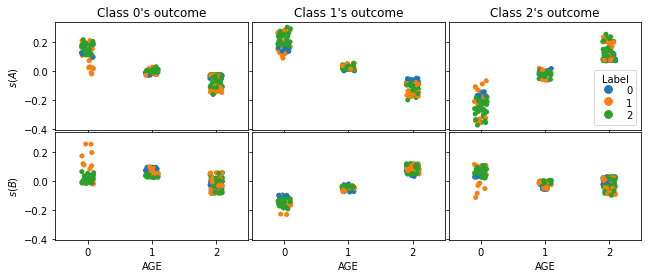

In [13]:
nrows, ncols = 2, 3
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*figsize[0], nrows*figsize[1]), sharey='all', sharex='all', squeeze=False, constrained_layout=True)
plot_dependence_curves_for_feature(node_ab, feature='AGE', labels=['A.0', 'A.1', 'A.2'], color=y_pred_a, color_label='$y_A$', kind='indiv', show_label_legend=False, axs=axs[0])
plot_dependence_curves_for_feature(node_ab, feature='AGE', labels=['B.0', 'B.1', 'B.2'], color=y_pred_b, color_label='$y_B$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[1])
#plot_dependence_curves_for_feature(node_ac, feature='AGE', labels=['C.0', 'C.1', 'C.2'], color=y_pred_a, color_label='$y_C$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[2])
axs[0][0].set_ylabel('$s(A)$')
axs[1][0].set_ylabel('$s(B)$')
#axs[2][0].set_ylabel('$s(C)$')
axs[0][0].set_title('Class 0\'s outcome')
axs[0][1].set_title('Class 1\'s outcome')
axs[0][2].set_title('Class 2\'s outcome')
axs[0][2].legend(title='Label', handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston-indiv-depplots-age.pdf', bbox_inches='tight', pad_inches=0)

In [8]:
node_ab.focus_class = '(1, 2)'

In [18]:
print(node_ab.descend().rule_from_counterfactuals()[0])

4.51 < LSTAT <= 6.27 and AGE <= 0 and 1.90 < DIS <= 5.65 and INDUS <= 8.14 and CRIM <= 14.6 and 4.27 < RAD <= 12.72 and 6.20 < RM <= 7.74 and ZN <= 89 and PTRATIO > 17.34


In [19]:
node_ab.data[node_ab.highlight]

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
51,0.30347,0.0,7.38,0.493,6.312,0.0,5.4159,5.0,287.0,19.6,6.15


Explanation for the instance classified $(1,2)$: B overestimates the increasing effect of low AGE ($=0$) on class 2's outcome. This could lead to $(1,2)$ classifications.

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


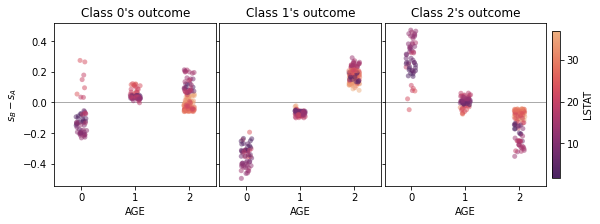

In [22]:
plot_dependence_curves_for_feature(node_ab, feature='AGE', labels=['0', '1', '2'], color='LSTAT', kind='indiv-diff', show_title=True, show_label_legend=False, figsize=(3.5, 3), alpha=0.5)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


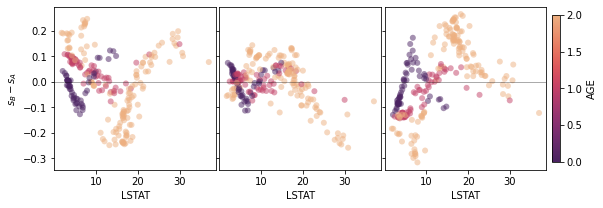

In [21]:
plot_dependence_curves_for_feature(node_ab, feature='LSTAT', labels=['0', '1', '2'], color='AGE', kind='indiv-diff', show_title=False, show_label_legend=False, figsize=(3.5, 3), alpha=0.5)

In [9]:
from clustering import draw_colorbar_if_necessary

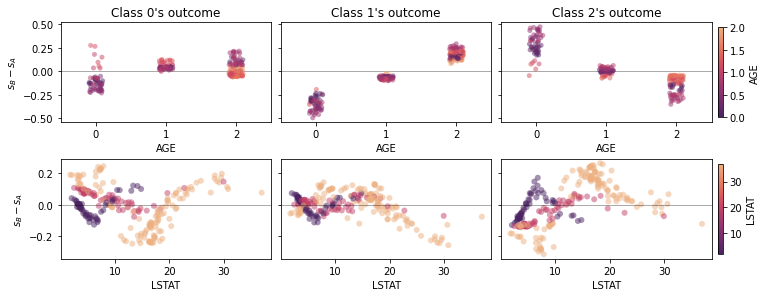

In [32]:
nrows, ncols = 2, 3
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*figsize[0], nrows*figsize[1]), sharey='row', sharex='row', squeeze=False, constrained_layout=True)
plot_dependence_curves_for_feature(node_ab, feature='AGE', labels=['0', '1', '2'], color='LSTAT', kind='indiv-diff', show_title=True, show_label_legend=False, figsize=(3.5, 3), alpha=0.5, axs=axs[0], adjust=False)
plot_dependence_curves_for_feature(node_ab, feature='LSTAT', labels=['0', '1', '2'], color='AGE', kind='indiv-diff', show_title=False, show_label_legend=False, figsize=(3.5, 3), alpha=0.5, axs=axs[1], adjust=False)
draw_colorbar_if_necessary(node_ab, 'AGE', axs=axs[0])
draw_colorbar_if_necessary(node_ab, 'LSTAT', axs=axs[1])
plt.savefig('figures/boston3-indiv-depplots-interactions.pdf', bbox_inches='tight', pad_inches=0)

In [10]:
from clustering import plot_dependence_curves_for_nodes

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


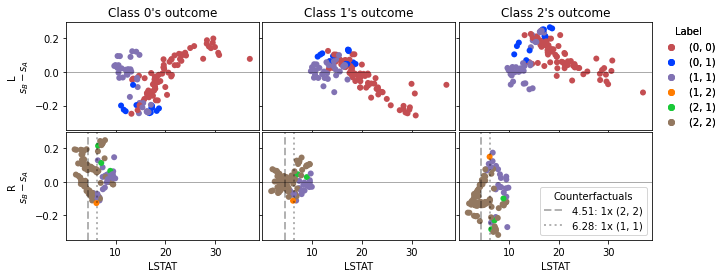

In [23]:
plot_dependence_curves_for_nodes(node_ab.get_left(), node_ab.get_right(), feature='LSTAT', kind='indiv-diff')

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


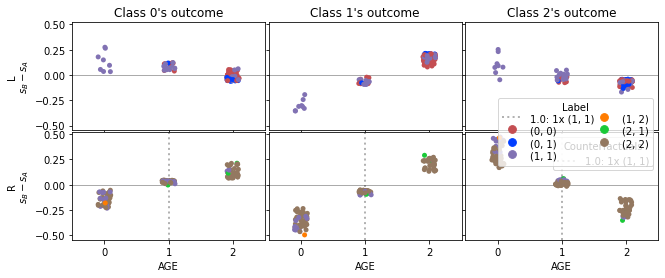

In [24]:
plot_dependence_curves_for_nodes(node_ab.get_left(), node_ab.get_right(), feature='AGE', kind='indiv-diff', show_legend=False)
ax = plt.gca()
fig = ax.figure
fig.legend(*ax.get_legend_handles_labels(), title='Label', loc='right', ncol=2,
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02, bbox_to_anchor=(0.9, 0.5))
plt.savefig('figures/boston-indiv-depplots-age-diff.pdf', bbox_inches='tight', pad_inches=0)

In [11]:
node_ab.focus_class = '(0, 1)'

In [26]:
print(node_ab.descend().rule_from_counterfactuals()[0])

10.24 < LSTAT <= 19.16 and ZN <= 5 and CRIM <= 6.1 and AGE > 0


Explanation for 12 of 13 instances classified $(0,1)$: For high LSTAT values (node 1, approx $>10$), B underestimates the effect of high AGE ($=2$) on class 0's outcome, and overestimates that on class 1's outcome, which could lead to $(0,1)$ classifications. Most of the instances classified $(0,1)$ (blue) have $AGE=2$ and are at the estrema in the dependence plot. They are the instances \#8, \#28, \#40, \#42, \#74, \#151, \#152, \#157, \#180, \#196, \#244, \#245.

In [12]:
print_indices = lambda indices: print(', '.join([f'\#{idx}' for idx in sorted(indices)]))

In [28]:
print_indices(node_ab.instance_indices[(node_ab.data['AGE'] == 2) & (node_ab.pred_classes == '(0, 1)')])

\#8, \#28, \#40, \#42, \#74, \#151, \#152, \#157, \#180, \#196, \#244, \#245


This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


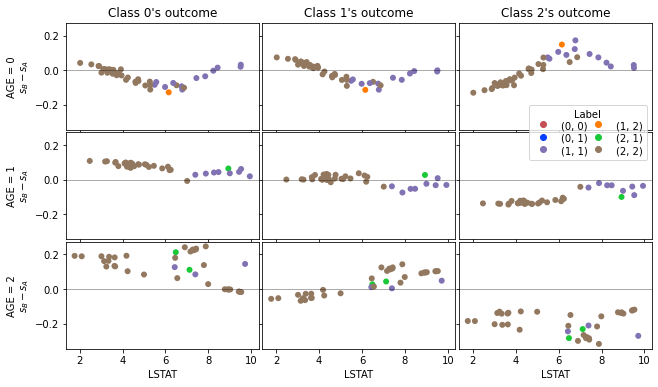

In [29]:
node1 = node_ab.get_right()
nodes = {
    'AGE = 0': node1.filter('AGE == 0'),
    'AGE = 1': node1.filter('AGE == 1'),
    'AGE = 2': node1.filter('AGE == 2')
}
plot_dependence_curves_for_nodes(feature='LSTAT', kind='indiv-diff', show_legend=False, **nodes)
ax = plt.gca()
fig = ax.figure
fig.legend(*ax.get_legend_handles_labels(), title='Label', loc='right', ncol=2,
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02, bbox_to_anchor=(0.9, 0.625))
plt.savefig('figures/boston-indiv-depplots-lstat-diff.pdf', bbox_inches='tight', pad_inches=0)

Explanation for instance \#51, classified $(1,2)$: For low LSTAT (approx. $<10$) and low AGE ($=0$), B overestimates the effect of LSTAT on class 2's outcome, while underestimating the effect on the other classes, which could lead to difference class $(1,2)$. Actually, thhe instance classified $(1,2)$ (orange) has peak overestimation for class 2 and peak underestimation for class 1.

In [30]:
node_ab.data.loc[node_ab.pred_classes == '(1, 2)']

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
51,0.30347,0.0,7.38,0.493,6.312,0.0,5.4159,5.0,287.0,19.6,6.15


Explanation for the instances \#77, \#101 and \#34, classified $(2,1)$: For $LSTAT<10$ and AGE values of 1 or 2, B overestimates class 1's outcome and underestimates 2's outcome.

In [31]:
node_ab.data.loc[node_ab.pred_classes == '(2, 1)']

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
101,0.10959,0.0,11.93,0.573,6.794,2.0,2.3889,1.0,273.0,21.0,6.48
34,4.55587,0.0,18.10,0.718,3.561,2.0,1.6132,24.0,666.0,20.2,7.12
77,0.05479,33.0,2.18,0.472,6.616,1.0,3.3700,7.0,222.0,18.4,8.93


This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


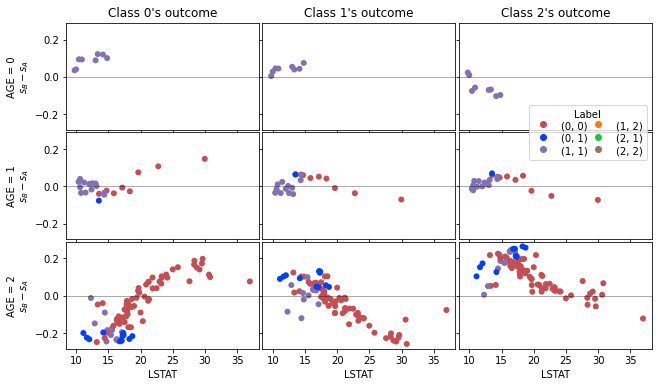

In [13]:
node1 = node_ab.get_left()
nodes = {
    'AGE = 0': node1.filter('AGE == 0'),
    'AGE = 1': node1.filter('AGE == 1'),
    'AGE = 2': node1.filter('AGE == 2')
}
plot_dependence_curves_for_nodes(feature='LSTAT', kind='indiv-diff', show_legend=False, **nodes)
ax = plt.gca()
fig = ax.figure
fig.legend(*ax.get_legend_handles_labels(), title='Label', loc='right', ncol=2,
           handleheight=1.5, columnspacing=0.02, labelspacing=0.02, bbox_to_anchor=(0.9, 0.625))
plt.savefig('figures/boston-indiv-depplots-lstat-diff2.pdf', bbox_inches='tight', pad_inches=0)

In [14]:
cluster = node_ab.descend().get_right()
cluster.instance_indices[cluster.highlight]

array([238, 151, 196,   8,  40,  28, 152])

In [15]:
cluster = cluster.descend().get_left()
cluster.instance_indices[cluster.highlight]

array([238, 151, 196])

In [16]:
cluster = cluster.descend().get_left()
cluster.instance_indices[cluster.highlight]

array([238])

In [17]:
print(cluster.descend().rule_from_counterfactuals()[0])

13.14 < LSTAT <= 14.09 and CRIM <= 0.7 and 224 < TAX <= 303 and ZN <= 0 and 15.36 < PTRATIO <= 17.03 and 4.81 < RM <= 6.51 and 12.37 < INDUS <= 16.66 and 2.03 < RAD <= 10.18 and AGE > 0 and DIS <= 5.36


Explanation for the instances classified $(0,1)$: For $LSTAT>10$ and AGE values of 1 or 2, B is overestimating class 1's outcome and underestimating class 0's outcome. This happens to a greater extent for $\text{AGE}=2$ than for $\text{AGE}=1$. This applies to the instances \#8, \#28, \#40, \#42, \#74, \#151, \#152, \#157, \#180, \#196, \#238, \#244 and \#245 (blue), which have peak overestimations of class 1's outcome and peak underestimations of class 0's outcome.

In [18]:
node_ab.data.loc[node_ab.pred_classes == '(0, 1)']

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,LSTAT
157,0.976170,0.0,21.89,0.624,5.757000,2.0,2.346000,4.0,437.0,21.2,17.310000
180,0.259150,0.0,21.89,0.624,5.693000,2.0,1.788300,4.0,437.0,21.2,17.190000
74,0.626837,0.0,21.89,0.624,5.725819,2.0,2.074288,4.0,437.0,21.2,17.251536
244,0.344745,0.0,21.89,0.624,5.685295,2.0,1.814662,4.0,437.0,21.2,17.348228
42,1.136037,0.0,8.14,0.538,5.695859,2.0,3.820836,4.0,307.0,21.0,18.257266
245,1.232470,0.0,8.14,0.538,6.142000,2.0,3.976900,4.0,307.0,21.0,18.720000
238,0.045600,0.0,13.89,0.550,5.888000,1.0,3.112100,5.0,276.0,16.4,13.510000
151,0.911039,0.0,8.14,0.538,6.020228,2.0,4.441690,4.0,307.0,21.0,17.066695
196,0.889075,0.0,8.14,0.538,5.614909,2.0,4.350506,4.0,307.0,21.0,16.796984
8,3.836840,0.0,18.10,0.770,6.251000,2.0,2.295500,24.0,666.0,20.2,14.190000


In [19]:
print_indices(node_ab.data.loc[(node_ab.pred_classes == '(0, 1)') & (node_ab.data['AGE'] == 2)].index)

\#8, \#28, \#40, \#42, \#74, \#151, \#152, \#157, \#180, \#196, \#244, \#245


In [20]:
node_ab.instance_indices[(node_ab.data['AGE'] == 1) & (node_ab.pred_classes == '(0, 1)')]

array([238])

In [22]:
for label in ['(0, 1)', '(1, 2)', '(2, 1)']:
    node_ab.focus_class = label
    print(f'{label}: {node_ab.rule_from_counterfactuals("LSTAT", "AGE")[0]}')

(0, 1): 10.24 < LSTAT <= 19.16 and AGE > 0
(1, 2): 4.51 < LSTAT <= 6.27 and AGE <= 0
(2, 1): 5.97 < LSTAT <= 9.05 and AGE > 0


Summary: For low LSTAT values in the range (4.51, 9.05], B tends to overestimate the label when AGE is 0 and underestimate the label when AGE is 1 or 2. For high LSTAT values in the range (10.24, 19.16], B tends to overestimate the label when AGE is 2 or 1.

In [24]:
from util import get_complexity

In [25]:
constraints = []
for label in ['(0, 1)', '(1, 2)', '(2, 1)']:
    node_ab.focus_class = label
    rule, constraint, _ = node_ab.rule_from_counterfactuals(latex=True)
    print(f'\item \emph{{Class {label}}}: ${rule}$')
    constraints.append(constraint)
get_complexity(constraints)

\item \emph{Class (0, 1)}: $10.24 < \text{LSTAT} \leq 19.16 \land \text{ZN} \leq 5 \land \text{CRIM} \leq 6.1 \land \text{AGE} > 0$
\item \emph{Class (1, 2)}: $4.51 < \text{LSTAT} \leq 6.27 \land \text{ZN} \leq 89 \land \text{INDUS} \leq 8.14 \land \text{CRIM} \leq 14.6 \land 6.20 < \text{RM} \leq 7.74 \land 4.27 < \text{RAD} \leq 12.72 \land 1.90 < \text{DIS} \leq 5.65 \land \text{AGE} \leq 0 \land \text{PTRATIO} > 17.34$
\item \emph{Class (2, 1)}: $5.97 < \text{LSTAT} \leq 9.05 \land \text{ZN} \leq 81 \land \text{INDUS} \leq 19.61 \land \text{CRIM} \leq 12.8 \land \text{RM} \leq 7.21 \land \text{DIS} \leq 4.17 \land \text{AGE} > 0$


Rules           3
Constraints    26
dtype: int64

# Comparison of A and C

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


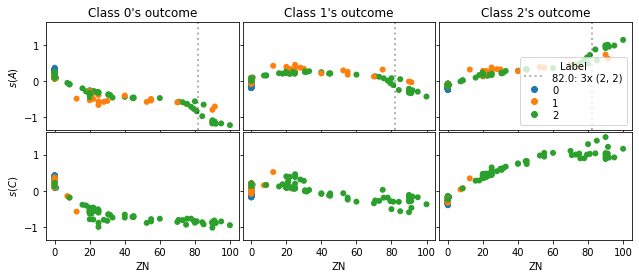

In [26]:
nrows, ncols = 2, 3
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*figsize[0], nrows*figsize[1]), sharey='all', sharex='all', squeeze=False, constrained_layout=True)
plot_dependence_curves_for_feature(node_ab, feature='ZN', labels=['A.0', 'A.1', 'A.2'], color=y_pred_a, color_label='$y_A$', kind='indiv', show_label_legend=False, axs=axs[0])
#plot_dependence_curves_for_feature(node_ab, feature='ZN', labels=['B.0', 'B.1', 'B.2'], color=y_pred_b, color_label='$y_B$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[1])
plot_dependence_curves_for_feature(node_ac, feature='ZN', labels=['C.0', 'C.1', 'C.2'], color=y_pred_a, color_label='$y_C$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[1])
axs[0][0].set_ylabel('$s(A)$')
#axs[1][0].set_ylabel('$s(B)$')
axs[1][0].set_ylabel('$s(C)$')
axs[0][0].set_title('Class 0\'s outcome')
axs[0][1].set_title('Class 1\'s outcome')
axs[0][2].set_title('Class 2\'s outcome')
axs[0][2].legend(title='Label', handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston-indiv-depplots-zn.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


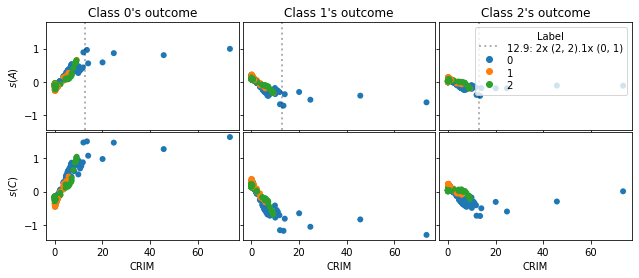

In [27]:
nrows, ncols = 2, 3
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*figsize[0], nrows*figsize[1]), sharey='all', sharex='all', squeeze=False, constrained_layout=True)
plot_dependence_curves_for_feature(node_ab, feature='CRIM', labels=['A.0', 'A.1', 'A.2'], color=y_pred_a, color_label='$y_A$', kind='indiv', show_label_legend=False, axs=axs[0])
plot_dependence_curves_for_feature(node_ac, feature='CRIM', labels=['C.0', 'C.1', 'C.2'], color=y_pred_a, color_label='$y_C$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[1])
axs[0][0].set_ylabel('$s(A)$')
axs[1][0].set_ylabel('$s(C)$')
axs[0][0].set_title('Class 0\'s outcome')
axs[0][1].set_title('Class 1\'s outcome')
axs[0][2].set_title('Class 2\'s outcome')
axs[0][2].legend(title='Label', handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston-indiv-depplots-crim.pdf', bbox_inches='tight', pad_inches=0)

This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.


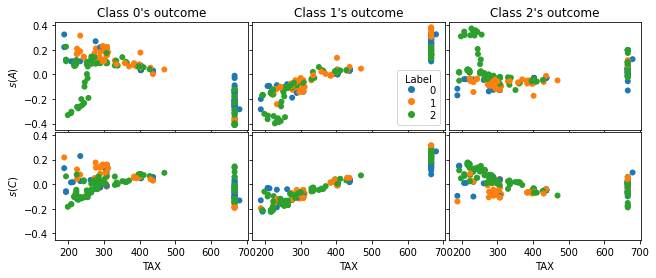

In [28]:
nrows, ncols = 2, 3
figsize = _DEFAULT_FIGSIZE
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*figsize[0], nrows*figsize[1]), sharey='all', sharex='all', squeeze=False, constrained_layout=True)
plot_dependence_curves_for_feature(node_ab, feature='TAX', labels=['A.0', 'A.1', 'A.2'], color=y_pred_a, color_label='$y_A$', kind='indiv', show_label_legend=False, axs=axs[0])
plot_dependence_curves_for_feature(node_ac, feature='TAX', labels=['C.0', 'C.1', 'C.2'], color=y_pred_a, color_label='$y_C$', kind='indiv', show_title=False, show_label_legend=False, axs=axs[1])
axs[0][0].set_ylabel('$s(A)$')
axs[1][0].set_ylabel('$s(C)$')
axs[0][0].set_title('Class 0\'s outcome')
axs[0][1].set_title('Class 1\'s outcome')
axs[0][2].set_title('Class 2\'s outcome')
axs[0][1].legend(title='Label', handleheight=1.5, columnspacing=0.02, labelspacing=0.02)
plt.savefig('figures/boston-indiv-depplots-tax.pdf', bbox_inches='tight', pad_inches=0)

In [29]:
from util import get_complexity

In [30]:
constraints = []
for label in ['(0, 1)', '(1, 0)', '(1, 2)', '(2, 1)']:
    node_ac.focus_class = label
    rule, constraint, _ = node_ac.rule_from_counterfactuals(latex=True)
    print(f'\item \emph{{Class {label}}}: ${rule}$')
    constraints.append(constraint)
get_complexity(constraints)

\item \emph{Class (0, 1)}: $10.48 < \text{LSTAT} \leq 14.89 \land \text{ZN} \leq 1 \land 12.37 < \text{INDUS} \leq 22.10 \land \text{CRIM} \leq 4.3 \land 4.81 < \text{RM} \leq 7.33 \land \text{AGE} > 0 \land \text{DIS} \leq 6.59 \land 13.36 < \text{PTRATIO} \leq 20.73$
\item \emph{Class (1, 0)}: $16.33 < \text{LSTAT} \leq 16.71 \land \text{ZN} \leq 0 \land 7.13 < \text{INDUS} \leq 9.14 \land 0.6 < \text{CRIM} \leq 1.1 \land 5.22 < \text{RM} \leq 5.75 \land \text{RAD} \leq 5.93 \land 288 < \text{TAX} \leq 326 \land \text{AGE} > 1 \land \text{DIS} > 2.93 \land 20.58 < \text{PTRATIO} \leq 21.38$
\item \emph{Class (1, 2)}: $3.58 < \text{LSTAT} \leq 11.58 \land \text{ZN} > 16 \land \text{INDUS} \leq 16.12 \land \text{CRIM} \leq 42.3 \land \text{RM} \leq 8.63 \land \text{RAD} \leq 13.35 \land \text{AGE} \leq 1 \land \text{DIS} > 1.94$
\item \emph{Class (2, 1)}: $6.05 < \text{LSTAT} \leq 7.41 \land \text{ZN} \leq 18 \land 9.80 < \text{INDUS} \leq 19.61 \land \text{CRIM} \leq 8.6 \land \text{R

Rules           4
Constraints    46
dtype: int64